In [1]:
import numpy as np
import matplotlib.pyplot as plt

from robot_utils.robot_data.img_data import ImgData
from robot_utils.robot_data.pose_data import PoseData
from robot_utils.transform import transform

import sys
sys.path.append("/home/masonbp/ford/fastsam3d")

from segment_track.observation import Observation
from segment_track.segment import Segment
from segment_track.tracker import Tracker
from segment_track.fastsam_wrapper import FastSAMWrapper

/home/masonbp/.envs/sparse_map/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
bag = "/home/masonbp/data/motlee_jan_2024/00/RR08.bag"
img_data = ImgData(
    data_file=bag,
    file_type='bag',
    topic="/RR08/d455/color/image_raw/compressed",
    time_tol=.0333333,
)
pose_data = PoseData(
    data_file=bag,
    file_type='bag',
    topic="/RR08/world",
    time_tol=.4,
    interp=True
)
t0 = np.max([img_data.t0, pose_data.t0])
img_data.set_t0(img_data.t0 - t0)
pose_data.set_t0(pose_data.t0 - t0)

<Axes: xlabel='x', ylabel='y'>

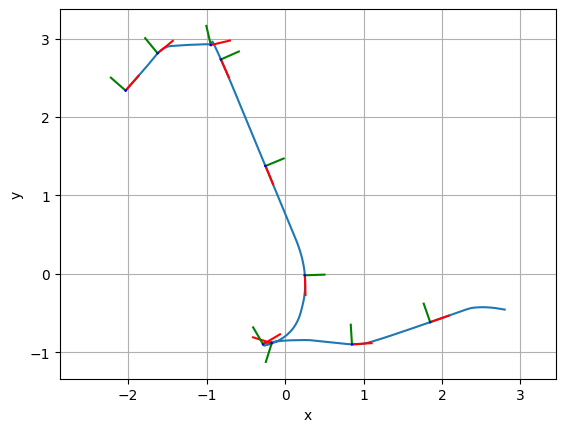

In [3]:
t0 = 104
tf = 120
pose_data.plot2d(t0=100, tf=120, pose=False, dt=.1)
pose_data.plot2d(t0=100, tf=120, trajectory=False, pose=True, dt=2., axis_len=.25)
# pose_data.plot2d(t0=t0, tf=tf, trajectory=True, pose=True, dt=2., axis_len=.25)

In [4]:
# T_BC = np.array([
#     - 0.0075156724929106855, 0.052520932013504995, 0.9985915413057593, 0.2101108603826516, - -0.999948500695071, -0.00641591694631477, 0.007863330555028802, 
#     -0.012497043173790775, - 0.00681986984179056, -0.9985992127526291, 0.05247000729150186, -0.0018691769405706252, - 0.0, 0.0, 0.0, 1.0
# ]).reshape((4, 4))

T_BC = np.array([0.031700555562911625, -0.03613229685936231, -0.9988440978954973, -0.3474637078784243, 0.9994936165740449, 
                 0.003899694308407531, 0.03158010152037666, -0.006910240015390966, 0.0027541250405664908, -0.9993394065621388, 0.03623762253919305, -0.11367298866636036, 0.0, 0.0, 0.0, 1.0
]).reshape((4, 4))
pose_data.T_postmultiply = T_BC
img_data.extract_params("/RR08/d455/color/camera_info")
cam_params = img_data.camera_params
fastsam = FastSAMWrapper(
    weights="/home/masonbp/tools/fastsam/weights/FastSAM-x.pt",
    imgsz=256,
    device='cpu'
)
img_area = cam_params.width * cam_params.height
fastsam.setup_filtering(
    ignore_people=True,
    yolo_det_img_size=(128, 128),
    allow_tblr_edges=[True, False, False, False],
    area_bounds=[img_area / 20**2, img_area / 3**2]
)


Fusing layers... 


In [5]:
all_observations = []
for t in np.arange(t0, tf, .05):
    try:
        img = img_data.img(t)
        pose = pose_data.T_WB(t)
    except:
        continue
    observations = fastsam.run(t, pose, img)
    all_observations.append(observations)
        
# print(segment.observations)
# print(len(segment.observations))


/home/masonbp/.envs/sparse_map/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

0: 160x256 7 objects, 84.6ms
Speed: 1.8ms preprocess, 84.6ms inference, 13.7ms postprocess per image at shape (1, 3, 256, 256)

0: 160x256 7 objects, 74.3ms
Speed: 0.4ms preprocess, 74.3ms inference, 10.6ms postprocess per image at shape (1, 3, 256, 256)

0: 160x256 8 objects, 80.6ms
Speed: 0.5ms preprocess, 80.6ms inference, 13.5ms postprocess per image at shape (1, 3, 256, 256)

0: 160x256 8 objects, 74.0ms
Speed: 0.4ms preprocess, 74.0ms inference, 12.3ms postprocess per image at shape (1, 3, 256, 256)

0: 160x256 10 objects, 74.6ms
Speed: 4.0ms preprocess, 74.6ms inference, 19.5ms postprocess per image at shape (1, 3, 256, 256)

0: 160x256 10 objects, 74.7

In [6]:
tracker = Tracker(
    camera_params=cam_params,
    pixel_std_dev=10.0,
    min_iou=0.5,
    min_sightings=3,
    max_t_no_sightings=0.25
)

for observations in all_observations:
    if len(observations) > 0:
        tracker.update(observations[0].time, observations)


In [7]:
print(len(tracker.segments))
print(len(tracker.segment_nursery))
print(len(tracker.segment_graveyard))

5
7
62


RuntimeError: CheiralityException

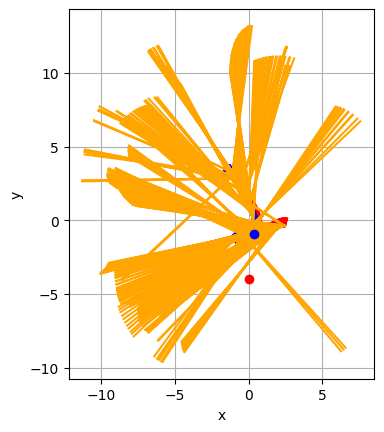

In [8]:
obs_lists = [seg.observations for seg in tracker.segments + tracker.segment_graveyard]
all_obs = [obs for obs_list in obs_lists for obs in obs_list]

plt.plot(0, -4, 'ro')
for obs in all_obs:
    pose_data.plot2d(t=obs.time, pose=True, axis_len=.5)
    
for obs in all_obs[:]:
    det_vec_c = np.linalg.inv(cam_params.K) @ np.array([obs.pixel[0], obs.pixel[1], 1]).reshape((3,1))
    det_vec = obs.pose[:3,:3] @ det_vec_c
    det_vec = det_vec[:2] / np.linalg.norm(det_vec[:2])
    det_vec *= 10
    plt.plot([obs.pose[0,3], obs.pose[0,3] + det_vec.item(0)], [obs.pose[1,3], obs.pose[1,3] + det_vec.item(1)], 'orange')

plt.gca().set_aspect('equal', adjustable='box')

for segment in tracker.segments:
    position = segment.reconstruction3D()
    plt.plot(position[0], position[1], 'bo')

In [9]:
boxes = np.array([
    [2.33, -2.03],
    [2.16, -1.65],
    [4.2, 0.5],
    [4.48, 1.73],
    [5.05, 3.24],
    [5.42, 3.43],
    [2.28, 1.94],
    [1.98, 2.19],
    [0.41, 2.39],
    [0.07, 2.64],
    [1.03, .48],
    [-1., 1.63],
    [-.86, -1.42],
    [-.33, -1.83],
    [-.73, -1.97],
    [-0.3, -3.46],
    [-1.79, 0.5],
    [-1.89, 1.13],
    [-2.86, 2.74],
    [-2.61, 2.78],
    [-3.37, 0.67],
    [-3.03, 0.19],
    [-2.36, -1.52],
])

missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one


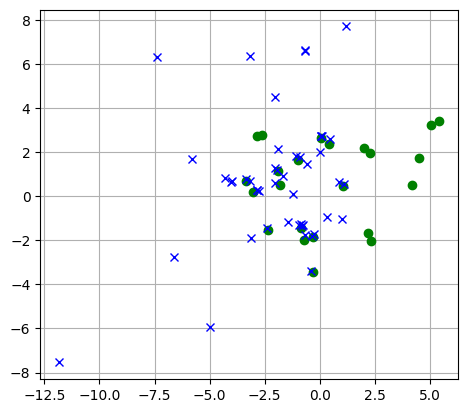

In [10]:
fig, ax = plt.subplots()
ax.plot(boxes[:,0], boxes[:,1], 'go')
ax.set_aspect('equal', adjustable='box')
ax.grid(True)
for segment in tracker.segments + tracker.segment_graveyard:
    try:
        position = segment.reconstruction3D()
        ax.plot(position[0], position[1], 'bx')
    except:
        print("missed this one")